In [1]:
from pytket import OpType

In [2]:
from pytket import Circuit

In [3]:
from pytket import Circuit

In [31]:
from pytket.circuit import Circuit
from pytket.circuit import CircBox
from pytket.circuit import QControlBox
from pytket.passes import DecomposeBoxes
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime
from pytket.circuit.display import render_circuit_jupyter



In [12]:
qft3_circ = Circuit(3)
qft3_circ.H(0)
qft3_circ.CU1(0.5, 1, 0)
qft3_circ.CU1(0.25, 2, 0)
qft3_circ.H(1)
qft3_circ.CU1(0.5, 2, 1)
qft3_circ.H(2)
qft3_circ.SWAP(0, 2)
render_circuit_jupyter(qft3_circ)

In [13]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [14]:
qft4_circ: Circuit = build_qft_circuit(4)
render_circuit_jupyter(qft4_circ)

In [17]:
qft4_box: CircBox = CircBox(qft4_circ)
qft_circ = Circuit(4).add_gate(qft4_box, [0, 1, 2, 3])
render_circuit_jupyter(qft_circ)

In [18]:
inv_qft4_box = qft4_box.dagger
render_circuit_jupyter(inv_qft4_box.get_circuit())

In [20]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

In [26]:
prep_circuit = Circuit(1).X(0)  # prepare the |1> eigenstate of U1
input_angle = 0.73  # angle as number of half turns
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops
qpe_circ_trivial = build_phase_estimation_circuit(
    4, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)
render_circuit_jupyter(qpe_circ_trivial)

In [33]:
phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

configuration = QuantinuumConfig(device_name="H1-1LE", user_group="iQuHACK_2024")


backend = NexusBackend(
    backend_config= configuration, 
    project= phase_est_project
)



DecomposeBoxes().apply(qpe_circ_trivial)


New project created: Phase Estimation Tutorial - 2024-02-03 18:55:11.506272

Started using project with name: Phase Estimation Tutorial - 2024-02-03 18:55:11.506272


True

In [34]:
compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)

In [35]:
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)
print(result.get_counts())

Counter({(0, 1, 1, 0): 918, (0, 1, 0, 1): 33, (0, 1, 1, 1): 19, (0, 1, 0, 0): 11, (0, 0, 1, 1): 5, (1, 0, 1, 1): 4, (0, 0, 1, 0): 2, (1, 0, 1, 0): 2, (0, 0, 0, 0): 1, (0, 0, 0, 1): 1, (1, 0, 0, 0): 1, (1, 0, 0, 1): 1, (1, 1, 1, 0): 1, (1, 1, 1, 1): 1})


In [36]:
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

In [37]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

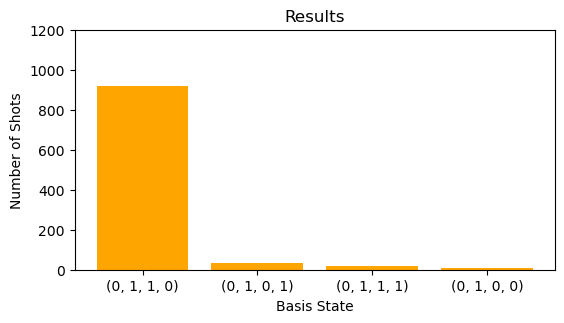

In [38]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

In [39]:
from pytket.backends.backendresult import BackendResult

In [40]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [41]:
theta = single_phase_from_backendresult(result)

In [42]:
print(theta)

0.375


In [43]:
print(input_angle / 2)

0.365


In [44]:
error = round(abs(input_angle - (2 * theta)), 3)
print(error)

0.02
